In [21]:
from DatasetReaders.AudioDatset import AudioDataset
from skimage.segmentation import mark_boundaries
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torchaudio
import random
import captum
import torch
import lime

device= "cpu"

## 1. Dataset Initializing 

In [10]:
NUM_SAMPLES= int(3.100772*16000)
BATCH_SIZE= 128
SAMPLE_RATE= 16000  
NUM_OF_MELS= 128
WIN_LENGTH= int(0.016 * SAMPLE_RATE)
HOP_LENGTH= int(0.004 * SAMPLE_RATE) 
FAKE_AUDIO_PATH= r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-norm\for-norm\training\fake"
REAL_AUDIO_PATH= r"D:\f_uni\sophomore_Uni\semester_1\Profesinal_Project\multimodal_deepfake_detection\datasets\FoR_dataset\for-norm\for-norm\training\real"
CORRUPTED_PATHS=[
    "file8319.wav_16k.wav_norm.wav_mono.wav_silence.wav",
    "file15440.wav_16k.wav_norm.wav_mono.wav_silence.wav",
    "file11064.wav_16k.wav_norm.wav_mono.wav_silence.wav"
]

mel_spectogram= torchaudio.transforms.MelSpectrogram(
    sample_rate= SAMPLE_RATE,
    n_fft= WIN_LENGTH*2,
    hop_length= HOP_LENGTH,
    n_mels= NUM_OF_MELS,
    window_fn= torch.hamming_window,
    win_length= WIN_LENGTH
)

audio_dataset= AudioDataset(
    FAKE_AUDIO_PATH,
    REAL_AUDIO_PATH,
    mel_spectogram,
    SAMPLE_RATE,
    NUM_SAMPLES,
    device,
    CORRUPTED_PATHS
)

real_indices= [i for i, label in enumerate(audio_dataset.labels) if label==0]
fake_indices= [i for i, label in enumerate(audio_dataset.labels) if label==1]
real_sample= random.sample(real_indices, 5000)
fake_sample= random.sample(fake_indices, 5000)
subset_indices= real_sample + fake_sample
random.shuffle(subset_indices)
small_dataset= Subset(audio_dataset, subset_indices)

## 2. Visualization for User
    1- the model takes the input raw
    2- genrating the melspectogram for the user
    3- preprocess the input
    4- making prediction using preprocessed (mel bands vs samples .....)
    5- the genrated should be something that is human freindly

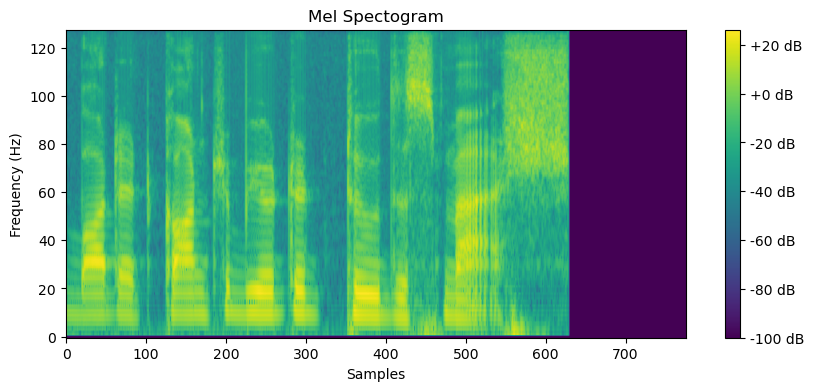

In [32]:
mel= small_dataset[0][0].squeeze(0).cpu()
mel_db= torchaudio.functional.amplitude_to_DB(mel, multiplier=10.0, amin=1e-10, db_multiplier=0.0)

plt.figure(figsize=(10, 4))
plt.imshow(mel_db, origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectogram")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Samples")
plt.show()

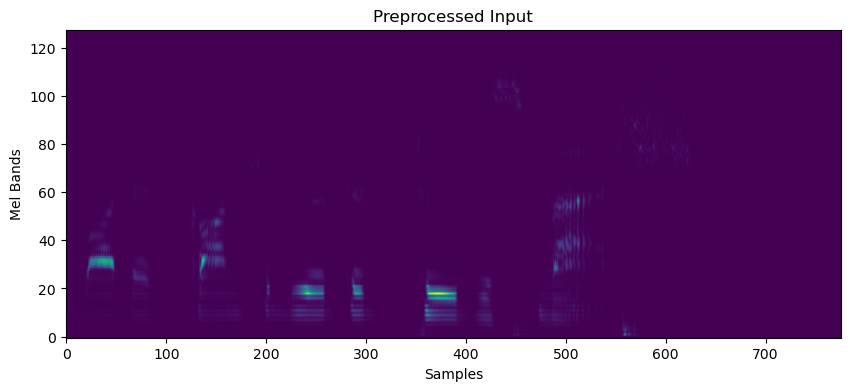

In [35]:
plt.figure(figsize=(10, 4))
plt.imshow(mel, origin='lower', aspect='auto')
plt.ylabel("Mel Bands")
plt.xlabel("Samples")
plt.title("Preprocessed Input")
plt.show()